In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
!pip install datasets --upgrade
!pip install transformers --upgrade
!pip install jiwer

  Obtaining dependency information for datasets from https://files.pythonhosted.org/packages/ec/93/454ada0d1b289a0f4a86ac88dbdeab54921becabac45da3da787d136628f/datasets-2.16.1-py3-none-any.whl.metadata
  Obtaining dependency information for pyarrow-hotfix from https://files.pythonhosted.org/packages/e4/f4/9ec2222f5f5f8ea04f66f184caafd991a39c8782e31f5b0266f101cb68ca/pyarrow_hotfix-0.6-py3-none-any.whl.metadata
  Obtaining dependency information for fsspec[http]<=2023.10.0,>=2023.1.0 from https://files.pythonhosted.org/packages/e8/f6/3eccfb530aac90ad1301c582da228e4763f19e719ac8200752a4841b0b2d/fsspec-2023.10.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.4/166.4 kB 17.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2023.12.2
    Uninstalling fsspec-2023.12.2:
      Successfully uninstalled fsspec-2023.12.2
  Attempting uninstall: datasets

In [5]:
import torch
torch.cuda.is_available()

True

In [6]:
import pandas as pd
df = pd.read_csv("/kaggle/input/common-voice/cv-valid-train.csv")

#convert all the text to uppercase.
df["text"] = df["text"].apply(lambda x: x.upper())

listnames = df["filename"].head(10000)
listnames = ['/kaggle/input/common-voice/cv-valid-train/'+x for x in listnames]

In [7]:
from datasets import load_dataset, load_metric, Audio
# dataset = load_dataset("audiofolder", data_dir="/kaggle/input/common-voice/cv-valid-train/cv-valid-train")
dataset = load_dataset("audiofolder", data_files={"train": listnames})


Resolving data files:   0%|          | 0/10000 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Generating train split: 0 examples [00:00, ? examples/s]

In [8]:
print(dataset)

ds = dataset['train']

DatasetDict({
    train: Dataset({
        features: ['audio'],
        num_rows: 10000
    })
})


Do some math: I have 195776 (~200 000) points,
so if i take batch size of 32 (per step) then 1 epoch is 6118 steps

In [9]:
ds = ds.cast_column("audio", Audio(sampling_rate=16_000))
ds = ds.add_column("text", df.iloc[:10000]["text"])
ds = ds.add_column("file", df.iloc[:10000]["filename"])

In [10]:
cv_ds = ds.train_test_split(test_size=0.3)

In [11]:
# check that the text and filename are aligned
cv_ds["train"][1]

{'audio': {'path': '/kaggle/input/common-voice/cv-valid-train/cv-valid-train/sample-009713.mp3',
  'array': array([-3.18323146e-12,  3.41060513e-12,  9.09494702e-13, ...,
          8.29440978e-08,  1.10714836e-07,  1.43812417e-06]),
  'sampling_rate': 16000},
 'text': 'THE MEN WERE SMOKING THEIR HOOKAHS AND TRADING STORIES FROM THE BATTLEFIELD',
 'file': 'cv-valid-train/sample-009713.mp3'}

In [12]:
import re
chars_to_ignore_regex = '[\,\?\.\!\-\;\:\"]'

def remove_special_characters(batch):
    batch["text"] = re.sub(chars_to_ignore_regex, '', batch["text"]).upper()
    return batch

cv_ds = cv_ds.map(remove_special_characters)

# def extract_all_chars(batch):
#   all_text = " ".join(batch["text"])
#   vocab = list(set(all_text))
#   return {"vocab": [vocab], "all_text": [all_text]}

# vocabs = cv_ds.map(extract_all_chars, batched=True, batch_size=-1, keep_in_memory=True, remove_columns=cv_ds.column_names["train"])

# vocab_list = list(set(vocabs["train"]["vocab"][0]) | set(vocabs["test"]["vocab"][0]))

# vocab_dict = {v: k for k, v in enumerate(vocab_list)}
# # vocab_dict
# vocab_dict["|"] = vocab_dict[" "]
# del vocab_dict[" "]
# vocab_dict["[UNK]"] = len(vocab_dict)
# vocab_dict["[PAD]"] = len(vocab_dict)
# print(len(vocab_dict))

Map:   0%|          | 0/7000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

In [13]:
# import json
# with open('/kaggle/working/vocab.json', 'w') as vocab_file:
#     json.dump(vocab_dict, vocab_file)

### Choice of Processor (Tokenizer + Feature Extractor)
Since the model is able to tokenize and process from the previous section (on common-voice), the processor does not need further finetuning, and we can use directly from 'facebook/wav2vec2-large-960h'. However, as the output is all in uppercase, the text labels are correspondingly converted to uppercase. 

In [14]:
# from transformers import Wav2Vec2CTCTokenizer
# tokenizer = Wav2Vec2CTCTokenizer("/kaggle/working/vocab.json", unk_token="[UNK]", pad_token="[PAD]", word_delimiter_token="|")

# from transformers import Wav2Vec2FeatureExtractor
# feature_extractor = Wav2Vec2FeatureExtractor(feature_size=1, sampling_rate=16000, padding_value=0.0, do_normalize=True, return_attention_mask=False)

from transformers import Wav2Vec2Processor
# processor = Wav2Vec2Processor(feature_extractor=feature_extractor, tokenizer=tokenizer)
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-large-960h")

def prepare_dataset(batch):
    audio = batch["audio"]

    # batched output is "un-batched" to ensure mapping is correct
    batch["input_values"] = processor(audio["array"], sampling_rate=audio["sampling_rate"]).input_values[0]
    
    with processor.as_target_processor():
        batch["labels"] = processor(batch["text"]).input_ids
    return batch

preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/843 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

Ignored unknown kwarg option normalize
Ignored unknown kwarg option normalize
Ignored unknown kwarg option normalize
Ignored unknown kwarg option normalize


In [15]:
cv_prepared = cv_ds.map(prepare_dataset, remove_columns=cv_ds.column_names["train"], num_proc=2)
print(cv_prepared)

Map (num_proc=2):   0%|          | 0/7000 [00:00<?, ? examples/s]

/opt/conda/lib/python3.10/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:156: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:156: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(


Map (num_proc=2):   0%|          | 0/3000 [00:00<?, ? examples/s]

/opt/conda/lib/python3.10/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:156: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:156: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(


DatasetDict({
    train: Dataset({
        features: ['input_values', 'labels'],
        num_rows: 7000
    })
    test: Dataset({
        features: ['input_values', 'labels'],
        num_rows: 3000
    })
})


In [16]:
# sanity check
import random
import IPython.display as ipd
import numpy as np

rand_int = random.randint(0, len(cv_prepared["train"]))

print("Target text:", cv_ds["train"][rand_int]["text"])
print("Target text:", cv_prepared["train"][rand_int]["labels"])
print("Input array shape:", np.asarray(cv_prepared["train"][rand_int]["input_values"]).shape)
# print("Sampling rate:", cv_ds["train"][rand_int]["audio"]["sampling_rate"])
ipd.Audio(data=np.asarray(cv_prepared["train"][rand_int]["input_values"]), autoplay=False, rate=16000)

Target text: NO ONE ATTACKS AN OASIS
Target text: [9, 8, 4, 8, 9, 5, 4, 7, 6, 6, 7, 19, 26, 12, 4, 7, 9, 4, 8, 7, 12, 10, 12]
Input array shape: (40704,)


# Training & Eval

In [17]:
import torch

from dataclasses import dataclass, field
from typing import Any, Dict, List, Optional, Union

@dataclass
class DataCollatorCTCWithPadding:
    """
    Data collator that will dynamically pad the inputs received.
    Args:
        processor (:class:`~transformers.Wav2Vec2Processor`)
            The processor used for proccessing the data.
        padding (:obj:`bool`, :obj:`str` or :class:`~transformers.tokenization_utils_base.PaddingStrategy`, `optional`, defaults to :obj:`True`):
            Select a strategy to pad the returned sequences (according to the model's padding side and padding index)
            among:
            * :obj:`True` or :obj:`'longest'`: Pad to the longest sequence in the batch (or no padding if only a single
              sequence if provided).
            * :obj:`'max_length'`: Pad to a maximum length specified with the argument :obj:`max_length` or to the
              maximum acceptable input length for the model if that argument is not provided.
            * :obj:`False` or :obj:`'do_not_pad'` (default): No padding (i.e., can output a batch with sequences of
              different lengths).
        max_length (:obj:`int`, `optional`):
            Maximum length of the ``input_values`` of the returned list and optionally padding length (see above).
        max_length_labels (:obj:`int`, `optional`):
            Maximum length of the ``labels`` returned list and optionally padding length (see above).
        pad_to_multiple_of (:obj:`int`, `optional`):
            If set will pad the sequence to a multiple of the provided value.
            This is especially useful to enable the use of Tensor Cores on NVIDIA hardware with compute capability >=
            7.5 (Volta).
    """

    processor: Wav2Vec2Processor
    padding: Union[bool, str] = True
    max_length: Optional[int] = None
    max_length_labels: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None
    pad_to_multiple_of_labels: Optional[int] = None

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lengths and need
        # different padding methods
        input_features = [{"input_values": feature["input_values"]} for feature in features]
        label_features = [{"input_ids": feature["labels"]} for feature in features]

        batch = self.processor.pad(
            input_features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors="pt",
        )
        with self.processor.as_target_processor():
            labels_batch = self.processor.pad(
                label_features,
                padding=self.padding,
                max_length=self.max_length_labels,
                pad_to_multiple_of=self.pad_to_multiple_of_labels,
                return_tensors="pt",
            )

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        batch["labels"] = labels

        return batch

In [18]:
from datasets import load_metric

data_collator = DataCollatorCTCWithPadding(processor=processor, padding=True)
wer_metric = load_metric("wer")

/tmp/ipykernel_26/2444964255.py:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  wer_metric = load_metric("wer")
/opt/conda/lib/python3.10/site-packages/datasets/load.py:752: FutureWarning: The repository for wer contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/wer/wer.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [19]:
def compute_metrics(pred):
    pred_logits = pred.predictions
    pred_ids = np.argmax(pred_logits, axis=-1)

    pred.label_ids[pred.label_ids == -100] = processor.tokenizer.pad_token_id

    pred_str = processor.batch_decode(pred_ids)
    # we do not want to group tokens when computing the metrics
    label_str = processor.batch_decode(pred.label_ids, group_tokens=False)

    wer = wer_metric.compute(predictions=pred_str, references=label_str)

    return {"wer": wer}

In [20]:
from transformers import Wav2Vec2ForCTC

model = Wav2Vec2ForCTC.from_pretrained(
    "facebook/wav2vec2-large-960h", 
#     ctc_loss_reduction="mean", 
#     pad_token_id=processor.tokenizer.pad_token_id,
)
model.freeze_feature_extractor()
# model.to('cuda:0')

pytorch_model.bin:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-large-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/models/wav2vec2/modeling_wav2vec2.py:1913: FutureWarning: The method `freeze_feature_extractor` is deprecated and will be removed in Transformers v5. Please use the equivalent `freeze_feature_encoder` method instead.
  warnings.warn(


### Choosing of hyperparameters:
batch size: maximum possible without CUDA-OOM (32 gives OOM)
max-steps: depends on the trend of the validation loss
learning rate: did some experiments starting from 1e-4. From there, slowly decrease as the lr is too high, as shown by the WER on the evaluation data increasing. This is likely because the model is already doing a good job (WER is ~0.10 even without finetuning on common voice), thus we don't need a high learning rate. Also since the learning rate is small and the dataset is so large that there is no repetition, I set weight decay to 0.

In [28]:
from transformers import TrainingArguments

repo_name = '/kaggle/working/models'

training_args = TrainingArguments(
  output_dir=repo_name,
  group_by_length=True,
  per_device_train_batch_size=8,
  gradient_accumulation_steps=2,  # increase by 2x for every 2x decrease in batch size
  evaluation_strategy="steps",
#   num_train_epochs=2,
  max_steps=100,
  fp16=True,
  gradient_checkpointing=True, 
  save_steps=20,
  eval_steps=20,
  logging_steps=20,
  learning_rate=1e-6,
#   weight_decay=0.005,
  warmup_steps=20,
  save_total_limit=2,
  report_to=["tensorboard"],
)

In [29]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=cv_prepared["train"],
    eval_dataset=cv_prepared["test"],
    tokenizer=processor.feature_extractor,
)

In [30]:
# torch.cuda.is_available()
# trainer.place_model_on_device

In [31]:
trainer.train()

Step,Training Loss,Validation Loss,Wer
20,535.778800,486.837402,0.108876
40,391.028400,349.265381,0.107711
60,351.576000,259.715515,0.107394
80,339.534600,226.211349,0.107500
100,271.151600,212.164276,0.107288


/opt/conda/lib/python3.10/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:156: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:156: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.

## Plot training and validation loss curves

In [39]:
# trainer.push_to_hub()
loss_df = pd.DataFrame(trainer.state.log_history)
trainloss_df = loss_df.dropna(axis=0, subset="loss")
evalloss_df = loss_df.dropna(axis=0, subset="eval_loss")
trainloss_df

,loss,learning_rate,epoch,step,eval_loss,eval_wer,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,535.7788,1.000000e-06,0.09,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,391.0284,7.500000e-07,0.18,40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,351.5760,5.000000e-07,0.27,60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,339.5346,2.500000e-07,0.37,80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,271.1516,0.000000e+00,0.46,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Text(0, 0.5, 'Loss')

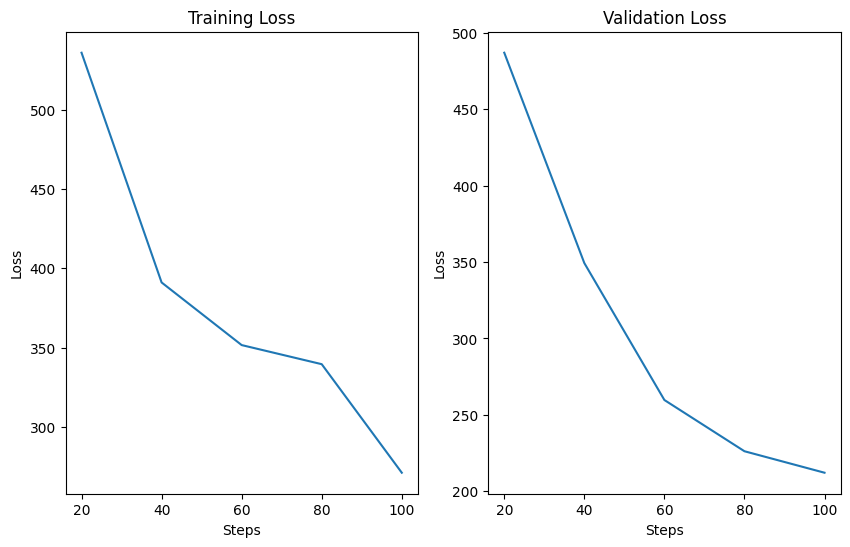

In [41]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(10,6))

axs[0].plot(trainloss_df["step"], trainloss_df["loss"])
axs[0].set_title("Training Loss")
axs[0].set_xlabel('Steps')
axs[0].set_ylabel('Loss')

axs[1].plot(evalloss_df["step"], evalloss_df["eval_loss"])
axs[1].set_title("Validation Loss")
axs[1].set_xlabel('Steps')
axs[1].set_ylabel('Loss')


# Prediction   
Load the model from the checkpoint with the best WER (checkpoint-100) for transcribing the files in cv-valid-test.
As I did the training on Kaggle, I saved the model checkpoint in a zip file with the name 'wav2vec2-large-960h-cv.zip'.

In [43]:
# save the checkpoint
import pathlib
from zipfile import ZipFile

directory = pathlib.Path("/kaggle/working/models/checkpoint-100")

with ZipFile('wav2vec2-large-960h-cv.zip', 'w') as myzip:
    for file_path in directory.iterdir():
        myzip.write(file_path, arcname=file_path.name)

In [44]:
# processor = Wav2Vec2Processor.from_pretrained(repo_name+'/checkpoint-90')
model = Wav2Vec2ForCTC.from_pretrained(repo_name+'/checkpoint-100')
model.to('cuda:0')

Wav2Vec2ForCTC(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2GroupNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
          (activation): GELUActivation()
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        )
        (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (5-6): 2 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): Wav2Vec2FeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (projection): Linear(in_features=512, out_features=1024, bias=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder

In [45]:
eval_ds = load_dataset("audiofolder", data_dir="/kaggle/input/common-voice/cv-valid-dev/cv-valid-dev")

Resolving data files:   0%|          | 0/4076 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [46]:
eval_df = pd.read_csv("/kaggle/input/common-voice/cv-valid-dev.csv")

#convert all the text to uppercase.
eval_df["text"] = eval_df["text"].apply(lambda x: x.upper())

In [48]:
eval_ds = eval_ds["train"]
eval_ds = eval_ds.cast_column("audio", Audio(sampling_rate=16_000))
eval_ds = eval_ds.add_column("text", eval_df["text"])
eval_ds = eval_ds.add_column("file", eval_df["filename"])

In [50]:
# check that the text and filename are aligned
eval_ds[1]

{'audio': {'path': '/kaggle/input/common-voice/cv-valid-dev/cv-valid-dev/sample-000001.mp3',
  'array': array([-9.92616735e-24, -5.37667398e-24, -8.27180613e-24, ...,
         -3.93260270e-05, -4.88106161e-05,  4.73947730e-05]),
  'sampling_rate': 16000},
 'text': 'THEN WHY SHOULD THEY BE SURPRISED WHEN THEY SEE ONE',
 'file': 'cv-valid-dev/sample-000001.mp3'}

In [52]:
eval_ds = eval_ds.map(remove_special_characters)
eval_prepared = eval_ds.map(prepare_dataset, num_proc=2)
print(eval_prepared)

Map:   0%|          | 0/4076 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/4076 [00:00<?, ? examples/s]

/opt/conda/lib/python3.10/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:156: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:156: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(


Dataset({
    features: ['audio', 'text', 'file', 'input_values', 'labels'],
    num_rows: 4076
})


In [53]:
def map_to_result(batch):
  with torch.no_grad():
    input_values = torch.tensor(batch["input_values"], device="cuda").unsqueeze(0)
    logits = model(input_values).logits

  pred_ids = torch.argmax(logits, dim=-1)
  batch["pred_str"] = processor.batch_decode(pred_ids)[0]
  batch["text"] = processor.decode(batch["labels"], group_tokens=False)
  
  return batch

results = eval_prepared.map(map_to_result)

Map:   0%|          | 0/4076 [00:00<?, ? examples/s]

In [ ]:
print(results["pred_str"])

In [55]:
print(results[2]["text"])
print(results[2]["pred_str"])
# show_random_elements(results.remove_columns(["speech", "sampling_rate"]))
print("Test WER: {:.3f}".format(wer_metric.compute(predictions=results["pred_str"], references=results["text"])))

A YOUNG ARAB ALSO LOADED DOWN WITH BAGGAGE ENTERED AND GREETED THE ENGLISHMAN
A YOUNG ARAB ALSO LOADED DOWN WITH BAGGAGE ENTERED AND GREETED THE ENGLISHMAN
Test WER: 0.106


In [56]:
# output results
eval_df["generated_text"] = results["pred_str"]
eval_df.to_csv("/kaggle/working/cv-valid-dev_finetuned.csv")

# Comparing model in 2d to finetuned model

In [5]:
import pandas as pd
from datasets import load_metric
import numpy as np

wer_metric = load_metric("wer")

df = pd.read_csv("cv-valid-dev_transcribed.csv")

predictions = df["generated_text"].apply(lambda x: str(x).lower()).values
reference = df["text"].values
wer = wer_metric.compute(predictions=predictions, references=reference)
    
print("WER of model in 2d: ", np.round(wer, 3))

ft_df = pd.read_csv("cv-valid-dev_finetuned.csv")

predictions = ft_df["generated_text"].apply(lambda x: str(x).lower()).values
reference = ft_df["text"].apply(lambda x: str(x).lower()).values
ft_wer = wer_metric.compute(predictions=predictions, references=reference)

print("WER of finetuned model: ", np.round(ft_wer, 3))

c:\Users\calic\Documents\GitHub\htx-tech-test\venv\lib\site-packages\datasets\load.py:752: FutureWarning: The repository for wer contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/wer/wer.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


WER of model in 2d:  0.108
WER of finetuned model:  0.106


# Transcribing the files in cv-valid-test (3c)

In [11]:
import librosa
import time
import pandas as pd
import torch
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC
from datasets import load_metric

df_test = pd.read_csv("cv-valid-test.csv")

# load model and processor
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-large-960h")
model = Wav2Vec2ForCTC.from_pretrained("wav2vec2-large-960h-cv")

transcriptions = []

start_time = time.time()
for id, row in df_test.iterrows():
    y, sr = librosa.load("C:/Users/calic/Documents/GitHub/htx-tech-test/cv-valid-test/"+row["filename"],  sr=16000)

    # tokenize
    input_values = processor(y, sampling_rate=sr, return_tensors="pt", padding="longest").input_values  # Batch size 1

    # retrieve logits
    logits = model(input_values).logits

    # take argmax and decode
    predicted_ids = torch.argmax(logits, dim=-1)
    transcription = processor.batch_decode(predicted_ids)
    transcriptions.append(transcription[0].lower())
end_time = time.time()

df_test["generated_text"] = transcriptions
df_test.to_csv("cv-valid-test_finetuned.csv")

wer_metric = load_metric("wer")
wer = wer_metric.compute(predictions=transcriptions, references=df_test["text"])
print("WER of finetuned model: ", np.round(wer, 3))
print("Average time taken to evaluate one clip: {}s".format(np.round(end_time-start_time/3995), 2) )


Some weights of the model checkpoint at wav2vec2-large-960h-cv were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weight_v', 'wav2vec2.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at wav2vec2-large-960h-cv and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0']
You should probably TRAIN this model on a down-

WER of finetuned model:  0.102
Average time taken to evaluate one clip: 1705069293.0s


# Analyzing performance before vs after finetuning

In [34]:
import pandas as pd
from evaluate import load
from jiwer import wer

# wer = load("wer")

finetuned = pd.read_csv("cv-valid-dev_finetuned.csv")
normal = pd.read_csv("cv-valid-dev_transcribed.csv")

finetuned["generated_text"].fillna(" ", inplace=True)
normal["generated_text"].fillna(" ", inplace=True)

finetuned["wer"] = finetuned.apply(lambda x: wer(x["text"], x["generated_text"]), axis=1)
normal["wer"] = normal.apply(lambda x: wer(x["text"], x["generated_text"].lower()), axis=1)

In [44]:
normal.groupby("gender")["wer"].mean()

gender
female    0.127258
male      0.115173
other     0.041919
Name: wer, dtype: float64

In [45]:
normal["gender"].value_counts()

gender
male      1135
female     394
other       11
Name: count, dtype: int64